In [3]:
import cupy as cp
import cv2
import types
import collections
import numpy as np
import random
import math
import time
import nvidia.dali.fn as fn
import nvidia.dali.types as types
from random import shuffle
from nvidia.dali.pipeline import Pipeline
from scipy.ndimage import zoom as scizoom
from cupyimg.skimage.transform import resize
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

batch_size = 4

In [4]:
def show_images(imgs):
    columns = 2
    rows = 2
    fig = plt.figure(figsize=(64, 64))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(imgs[j])

In [21]:
class Augmenter:
    def __init__(self):
        self.snow_param = [(0.1, 0.3, 3, 0.5, 10, 4, 0.8),
                         (0.2, 0.3, 2, 0.5, 12, 4, 0.7),
                         (0.55, 0.3, 4, 0.9, 12, 8, 0.7),
                         (0.55, 0.3, 4.5, 0.85, 12, 8, 0.65),
                         (0.55, 0.3, 2.5, 0.85, 12, 12, 0.55)]#[snow_severity - 1]
        self.fog_param = [(1.5, 2), (2., 2), (2.5, 1.7), (2.5, 1.5), (3., 1.4)]#[fog_severity - 1]
        self.frost_param = [(1, 0.4),
                            (0.8, 0.6),
                            (0.7, 0.7),
                            (0.65, 0.7),
                            (0.6, 0.75)]#[frost_severity - 1]
        
    def next_power_of_2(self, x):
        return 1 if x == 0 else 2 ** (x - 1).bit_length()

    def getOptimalKernelWidth1D(self, radius, sigma):
        return radius * 2 + 1

    def gauss_function(self, x, mean, sigma):
        return (cp.exp(- x**2 / (2 * (sigma**2)))) / (cp.sqrt(2 * cp.pi) * sigma)

    def getMotionBlurKernel_cupy(self, width, sigma):
        k = self.gauss_function(cp.arange(width), 0, sigma)
        Z = cp.sum(k)
        return k/Z

    def shift_cupy(self, image, dx, dy):
        if(dx < 0):
            shifted = cp.roll(image, shift=image.shape[1]+dx, axis=1)
            shifted[:,dx:] = shifted[:,dx-1:dx]
        elif(dx > 0):
            shifted = cp.roll(image, shift=dx, axis=1)
            shifted[:,:dx] = shifted[:,dx:dx+1]
        else:
            shifted = image

        if(dy < 0):
            shifted = cp.roll(shifted, shift=image.shape[0]+dy, axis=0)
            shifted[dy:,:] = shifted[dy-1:dy,:]
        elif(dy > 0):
            shifted = cp.roll(shifted, shift=dy, axis=0)
            shifted[:dy,:] = shifted[dy:dy+1,:]
        return shifted

    def rgb2gray_cupy(self, rgb):
        return cp.dot(rgb[..., :3], cp.array([0.1140, 0.5870, 0.2989]))
    
    def wibbledmean(self, array, wibble):
            return array / 4 + wibble * cp.random.uniform(-wibble, wibble,
                                                          array.shape)
    def fillsquares(self, maparray, mapsize, stepsize, wibble):
        cornerref = maparray[0:mapsize:stepsize, 0:mapsize:stepsize]
        squareaccum = cornerref + cp.roll(cornerref, shift=-1, axis=0)
        squareaccum += cp.roll(squareaccum, shift=-1, axis=1)
        maparray[stepsize // 2:mapsize:stepsize, stepsize // 2:mapsize:stepsize] = self.wibbledmean(squareaccum, wibble)

    def filldiamonds(self, maparray, stepsize, wibble):
        mapsize = maparray.shape[0]
        drgrid = maparray[stepsize // 2:mapsize:stepsize, stepsize // 2:mapsize:stepsize]
        ulgrid = maparray[0:mapsize:stepsize, 0:mapsize:stepsize]
        ldrsum = drgrid + cp.roll(drgrid, 1, axis=0)
        lulsum = ulgrid + cp.roll(ulgrid, -1, axis=1)
        ltsum = ldrsum + lulsum
        maparray[0:mapsize:stepsize, stepsize // 2:mapsize:stepsize] = self.wibbledmean(ltsum, wibble)
        tdrsum = drgrid + cp.roll(drgrid, 1, axis=1)
        tulsum = ulgrid + cp.roll(ulgrid, -1, axis=0)
        ttsum = tdrsum + tulsum
        maparray[stepsize // 2:mapsize:stepsize, 0:mapsize:stepsize] = self.wibbledmean(ttsum, wibble)


    def plasma_fractal_cupy(self, mapsize = 256, wibbledecay=3):
        assert (mapsize & (mapsize - 1) == 0)
        maparray = cp.empty((mapsize, mapsize), dtype=cp.float_)
        maparray[0, 0] = 0
        stepsize = mapsize
        wibble = 100

        while stepsize >= 2:
            self.fillsquares(maparray, mapsize, stepsize, wibble)
            self.filldiamonds(maparray, stepsize, wibble)
            stepsize //= 2
            wibble /= wibbledecay

        maparray -= maparray.min()
        return maparray / maparray.max()

    def clipped_zoom_cupy(self, img, zoom_factor):
        # clipping along the width dimension:
        ch0 = int(cp.ceil(img.shape[0] / float(zoom_factor)))
        top0 = (img.shape[0] - ch0) // 2

        # clipping along the height dimension:
        ch1 = int(cp.ceil(img.shape[1] / float(zoom_factor)))
        top1 = (img.shape[1] - ch1) // 2

        img = cp.array(scizoom(cp.asnumpy(img[top0:top0 + ch0, top1:top1 + ch1]),
                      (zoom_factor, zoom_factor, 1), order=1))

        return img

    def _motion_blur_cupy(self, x, radius, sigma, angle):
        width = self.getOptimalKernelWidth1D(radius, sigma)
        kernel = self.getMotionBlurKernel_cupy(width, sigma)
        point = (width * cp.sin(cp.deg2rad(angle)), width * cp.cos(cp.deg2rad(angle)))
        hypot = math.hypot(point[0], point[1])

        blurred = cp.zeros_like(x, dtype=np.float32)
        for i in range(width):
            dy = -math.ceil(((i*point[0]) / hypot) - 0.5)
            dx = -math.ceil(((i*point[1]) / hypot) - 0.5)
            if (cp.abs(dy) >= x.shape[0] or cp.abs(dx) >= x.shape[1]):
                # simulated motion exceeded image borders
                break
            shifted = self.shift_cupy(x, dx, dy)
            blurred = blurred + kernel[i] * shifted
        return blurred
    
    def fog_cupy(self, img, severity=1):
        params = self.snow_param[np.random.randint(5)]
        shape = cp.array(img).shape
        max_side = max(shape)
        map_size = self.next_power_of_2(int(max_side))

        img = cp.array(img) / 255.
        max_val = cp.amax(img)

        img_shape = cp.array(img).shape
        if len(img_shape) < 3 or img_shape[2] < 3:
            img += params[0] * self.plasma_fractal_cupy(mapsize=map_size, wibbledecay=params[1])[
                        :shape[0], :shape[1]]
        else:
            img += params[0] * self.plasma_fractal_cupy(mapsize=map_size, 
                                                                wibbledecay=params[1])[:shape[0],
                 :shape[1]][..., cp.newaxis]

        return cp.clip(img * max_val / (max_val + params[0]), 0, 1) * 255

    def frost_cupy(self, x, severity=1):
        params = self.frost_param[np.random.randint(5)]
        idx = cp.random.randint(5) + 1
        filename = './frost/frost' + str(idx) + '.npy'
        frost = cp.load(filename)
        frost_shape = frost.shape
        x_shape = cp.array(x).shape

        # resize the frost image so it fits to the image dimensions
        scaling_factor = 1
        if frost_shape[0] >= x_shape[0] and frost_shape[1] >= x_shape[1]:
            scaling_factor = 1
        elif frost_shape[0] < x_shape[0] and frost_shape[1] >= x_shape[1]:
            scaling_factor = x_shape[0] / frost_shape[0]
        elif frost_shape[0] >= x_shape[0] and frost_shape[1] < x_shape[1]:
            scaling_factor = x_shape[1] / frost_shape[1]
        elif frost_shape[0] < x_shape[0] and frost_shape[1] < x_shape[
            1]:  # If both dims are too small, pick the bigger scaling factor
            scaling_factor_0 = x_shape[0] / frost_shape[0]
            scaling_factor_1 = x_shape[1] / frost_shape[1]
            scaling_factor = cp.maximum(scaling_factor_0, scaling_factor_1)

        scaling_factor *= 1.1
        new_shape = (int(cp.ceil(frost_shape[1] * scaling_factor)),
                     int(cp.ceil(frost_shape[0] * scaling_factor)))
        frost_rescaled = resize(frost, (new_shape[1], new_shape[0]), preserve_range = True).astype(np.uint8)

        # randomly crop
        x_start, y_start = cp.random.randint(0, frost_rescaled.shape[0] - x_shape[
            0]), cp.random.randint(0, frost_rescaled.shape[1] - x_shape[1])

        if len(x_shape) < 3 or x_shape[2] < 3:
            frost_rescaled = frost_rescaled[x_start:x_start + x_shape[0],
                             y_start:y_start + x_shape[1]]
            frost_rescaled = self.rgb2gray_cupy(frost_rescaled)
        else:
            frost_rescaled = frost_rescaled[x_start:x_start + x_shape[0],
                             y_start:y_start + x_shape[1]][..., [2, 1, 0]]

        return cp.clip(params[0] * cp.array(x) + params[1] * frost_rescaled, 0, 255)

    def snow_cupy(self, x, severity=1):
        params = self.snow_param[np.random.randint(5)]
        x = cp.array(x, dtype=np.float32) / 255.
        snow_layer = cp.random.normal(size=x.shape[:2], loc=params[0],
                                      scale=params[1])

        snow_layer = self.clipped_zoom_cupy(snow_layer[..., np.newaxis], params[2])
        snow_layer[snow_layer < params[3]] = 0

        snow_layer = cp.clip(snow_layer.squeeze(), 0, 1)


        snow_layer = self._motion_blur_cupy(snow_layer, radius=params[4], 
                                            sigma=params[5], angle=np.random.uniform(-135, -45))

        # The snow layer is rounded and cropped to the img dims
        snow_layer = cp.round_(snow_layer * 255).astype(cp.uint8) / 255.
        snow_layer = snow_layer[..., cp.newaxis]
        snow_layer = snow_layer[:x.shape[0], :x.shape[1], :]

        if len(x.shape) < 3 or x.shape[2] < 3:
            x = params[6] * x + (1 - params[6]) * cp.maximum(x, x.reshape(x.shape[0],
                                                        x.shape[1]) * 1.5 + 0.5)
            snow_layer = snow_layer.squeeze(-1)
        else:
            x = params[6] * x + (1 - params[6]) * cp.maximum(x, self.rgb2gray_cupy(x).reshape(
                x.shape[0], x.shape[1], 1) * 1.5 + 0.5)
        try:
            return cp.clip(x + snow_layer + np.rot90(snow_layer, k=2), 0, 1) * 255
        except ValueError:
            print('ValueError for Snow, Exception handling')
            x[:snow_layer.shape[0], :snow_layer.shape[1]] += snow_layer + np.rot90(
                snow_layer, k=2)
            return cp.clip(x, 0, 1) * 255
            
    def augmenter(self, img, choises, seed=0):
        if choises[0] == 1:
            img = self.fog_cupy(img)
        if choises[1] == 1:
            img = self.frost_cupy(img)
        if choises[2] == 1:
            img = self.snow_cupy(img)

        return cp.array(img, dtype = np.uint8)

In [22]:
class ExternalInputIterator(object):
    def __init__(self, batch_size, imgs):
        self.batch_size = batch_size
        self.imgs = imgs

    def __iter__(self):
        self.i = 0
        self.n = self.imgs.shape[0]
        return self

    def __next__(self):
        batch = []
        labels = []
        choises = cp.random.randint(2, size=(4,3))
        for _ in range(self.batch_size):
            batch.append(self.imgs[self.i])
            labels.append(cp.array([0], dtype = np.uint8))
            self.i = (self.i + 1) % self.n
        return (batch, labels, choises)

In [23]:
image_dir = './images'

img1 = cv2.resize(cv2.cvtColor(cv2.imread(image_dir + '/1.png'),cv2.COLOR_BGR2RGB), (512,512))
img2 = cv2.resize(cv2.cvtColor(cv2.imread(image_dir + '/2.png'),cv2.COLOR_BGR2RGB), (512,512))
img3 = cv2.resize(cv2.cvtColor(cv2.imread(image_dir + '/3.png'),cv2.COLOR_BGR2RGB), (512,512))
img4 = cv2.resize(cv2.cvtColor(cv2.imread(image_dir + '/4.png'),cv2.COLOR_BGR2RGB), (512,512))

imgs = cp.array([img1, img2, img3, img4])

start = time.time()
eii = ExternalInputIterator(batch_size, imgs)
end = time.time()
print("Time elapsed:", end - start, "sec")

Time elapsed: 5.364418029785156e-05 sec


In [24]:
aug = Augmenter()
aug.augmenter(img1, [1, 1, 1])

array([[[247, 249, 252],
        [255, 255, 255],
        [248, 249, 252],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[244, 246, 249],
        [239, 241, 244],
        [255, 255, 255],
        ...,
        [235, 239, 249],
        [254, 255, 255],
        [255, 255, 255]],

       [[252, 254, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [248, 252, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[214, 217, 223],
        [228, 230, 236],
        [186, 188, 194],
        ...,
        [190, 192, 195],
        [203, 205, 208],
        [213, 215, 218]],

       [[246, 248, 254],
        [233, 235, 242],
        [196, 198, 204],
        ...,
        [209, 211, 214],
        [201, 203, 207],
        [185, 186, 190]],

       [[254, 255, 255],
        [198, 200, 206],
        [228, 231, 237],
        ...,
        [186, 187, 191],
        [189, 191, 195],
        [192, 194, 197]]

In [25]:
aug = Augmenter()
pipe = Pipeline(batch_size=batch_size, num_threads=2, device_id=0, exec_async=False, exec_pipelined=False)
with pipe:
    imgs, labels, choises = fn.external_source(source=eii, num_outputs=3, device="gpu")
    aug_imgs = fn.python_function(imgs, choises, device='gpu', function=aug.augmenter, num_outputs=1)
    pipe.set_outputs(aug_imgs, labels)
    
pipe.build()

In [26]:
pipe_out = pipe.run()

out = pipe_out[0].as_cpu().as_array()
outRGB = np.copy(out)
#for i in range(len(out)):
#    outRGB[i] = cv2.cvtColor(out[i],cv2.COLOR_BGR2RGB)


img1 = outRGB[0]
img2 = outRGB[1]
img3 = outRGB[2]
img4 = outRGB[3]

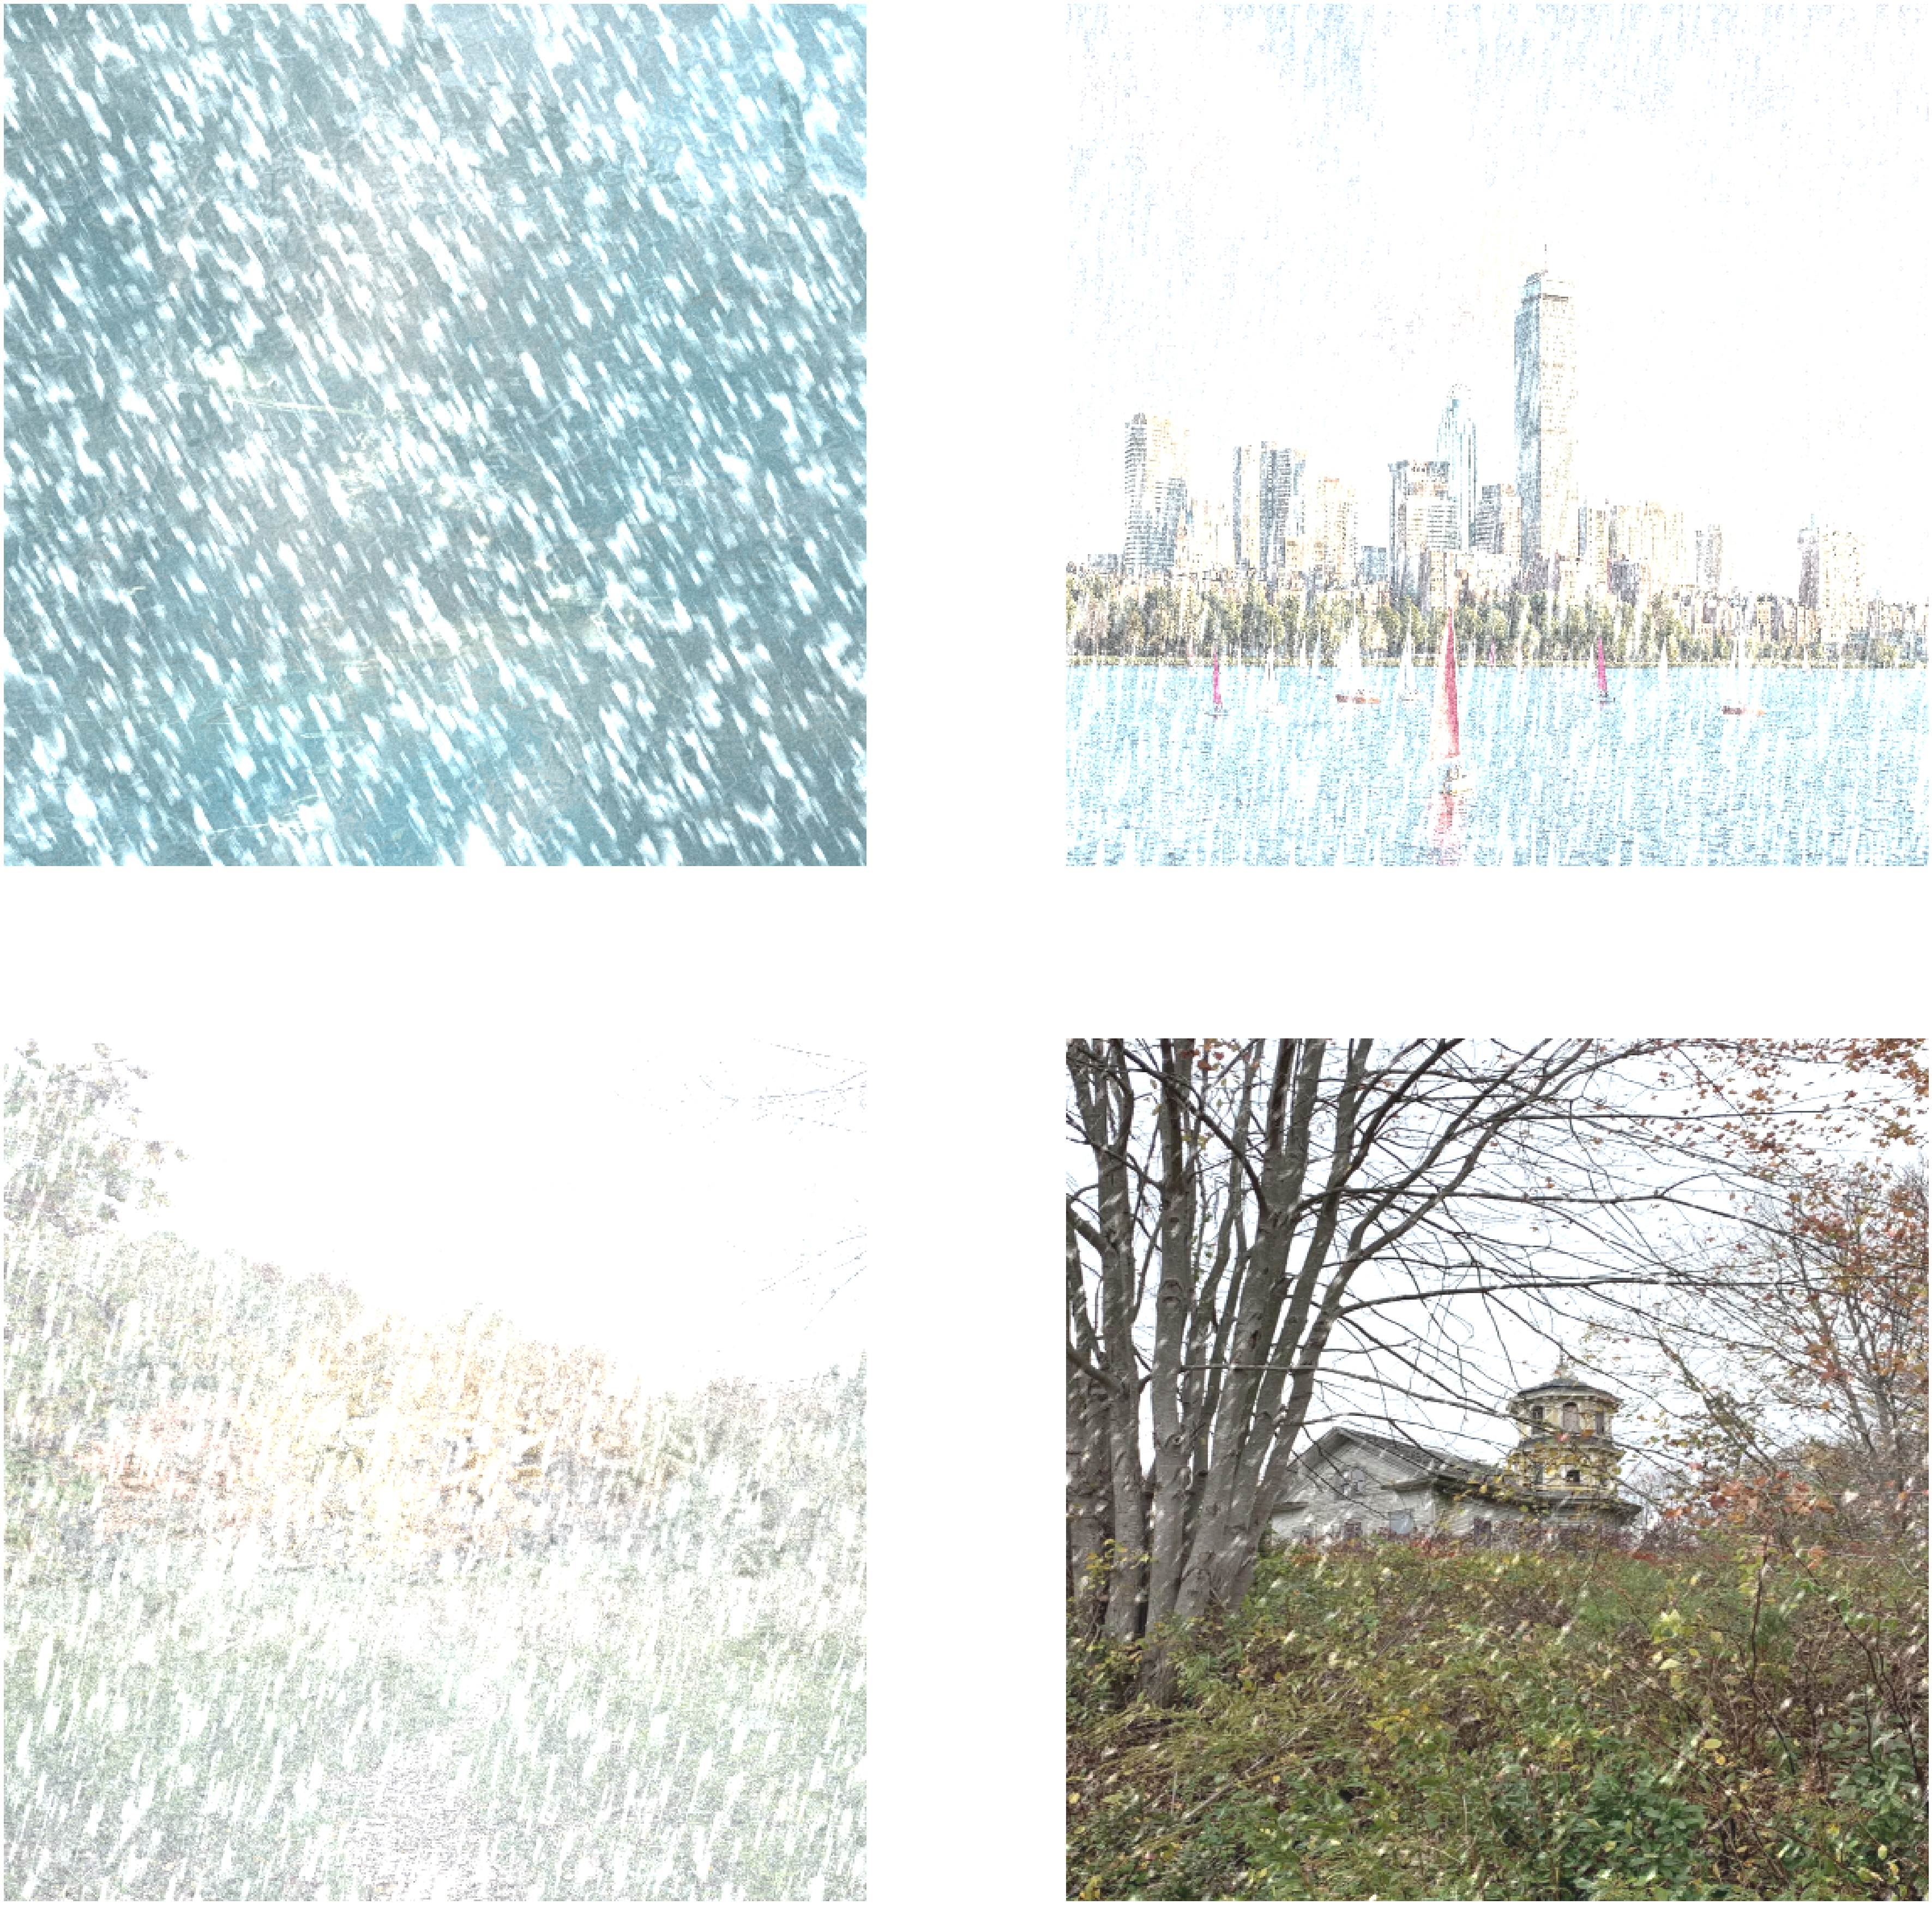

In [27]:
show_images(outRGB)